# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/variational_autoencoder_Per_Band/224_band1.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)
The train shape is: (130, 1025)
The test shape is: (33, 1025)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0         1         2         3         4         5  \
41001 201546  0.137376 -0.251571 -0.041015  0.116289 -0.104826  0.624667   
      201547 -0.388852  0.195847 -0.471414  0.257487 -0.338511 -0.061649   
      201548  0.179064  0.113284 -0.081055 -0.464302 -0.100072  0.046481   
      201549  0.202825 -0.079182  0.334063 -0.028436  0.189727  0.434458   
      201550 -0.544718 -0.089121  0.446134  0.458526  0.503007  0.186108   

                     6         7         8         9  ...      1015      1016  \
41001 201546  0.132963 -0.025964  0.318302  0.344138  ...  0.008284 -0.232800   
      201547 -0.481475  0.188154  0.279914 -0.414623  ...  0.163363  0.002214   
      201548 -0.171165  0.586963 -0.160149 -0.057907  ...  0.240420  0.146197   
      201549 -0.293694 -0.542087 -0.318238  0.322429  ...  0.110313  0.291979   
      201550  0.251876 -0.774996 -0.210795 -0.288728  ...  0.157694  0.459817   

                  1017      1018      1019      1020      1021      1022  \
41001 201546  0.291632  0.198956 -0.190589  0.264445 -0.631498  0.478959   
      201547  0.557021 -0.222174  0.383211 -0.254743  0.286436 -0.020192   
      201548  0.439845 -0.170368  0.000306  0.072528  0.282311 -0.571425   
      201549 -0.158532  0.629422  0.267063 -0.619439 -0.358584  0.223493   
      201550 -0.259158 -0.286926 -0.561520  0.090629 -0.673773 -0.337321   

                  1023    Labels  
41001 201546 -0.701127 -0.861740  
      201547 -0.164758 -0.854589  
      201548 -0.108397 -0.856973  
      201549 -0.319473 -0.856973  
      201550  0.126846 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3         4         5  \
41001 201820  0.037596 -0.389032  0.104377 -0.207403  0.144251  0.348953   
      201821 -0.129857  0.360287  0.050795  0.433799 -0.374451  0.282232   
      201822  0.249687 -0.046266  0.324886 -0.193008  0.770017 -0.105244   
      201823  0.102523  0.073182  0.279181  0.184174  0.013099 -0.159452   
      201824  0.838676  0.073342 -0.047140 -0.359032 -0.070033 -0.017459   

                     6         7         8         9  ...      1015      1016  \
41001 201820 -0.336956 -0.039455  0.040322 -0.160650  ...  0.092636  0.223428   
      201821 -0.338736 -0.014762 -0.411172 -0.215792  ...  0.057773  0.350521   
      201822  0.293970 -0.351222 -0.134279 -0.772908  ...  0.818870  0.133444   
      201823  0.042015  0.496606  0.285928 -0.119735  ... -0.048124  0.027891   
      201824 -0.671297  0.173730 -0.575823  0.076880  ...  0.015985  0.428736   

                  1017      1018      1019      1020      1021      1022  \
41001 201820 -0.230277 -0.416756  0.435238 -0.107750 -0.107184  0.230300   
      201821  0.087360 -0.127979  0.186410 -0.067329 -0.238000 -0.625605   
      201822  0.098135  0.077639  0.469923 -0.432356 -0.511155  0.194695   
      201823  0.353611 -0.258296 -0.180446  0.367915  0.124259 -0.367021   
      201824  0.155322 -0.109667  0.236220  0.188276 -0.027900 -0.117591   

                  1023    Labels  
41001 201820  0.084210 -0.949940  
      201821  0.042981 -0.961859  
      201822  0.161145 -0.940405  
      201823 -0.125889 -0.961859  
      201824  0.581908 -0.954708  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 1025)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 1024)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 1024)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

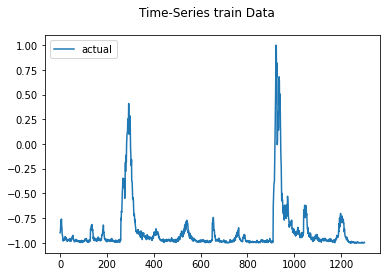

2023-03-14 14:16:52.417641: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-14 14:16:52.417682: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-14 14:16:52.417703: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-14 14:16:52.417920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 14:16:52.517346: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 58.127
Test RMSE: 66.788
Test sMAPE: 110.738
Test R Squared: -3.616
{'mae': 58.12681637966271, 'rmse': 66.78807208907708, 'smape': 110.73839641661554, 'r2': -3.6157238316402633}


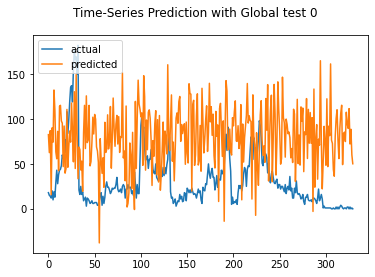

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 50.507
Test RMSE: 63.054
Test sMAPE: 115.953
Test R Squared: -3.114
{'mae': 50.5072353290789, 'rmse': 63.05370362528789, 'smape': 115.95292608296347, 'r2': -3.1139897360205318}


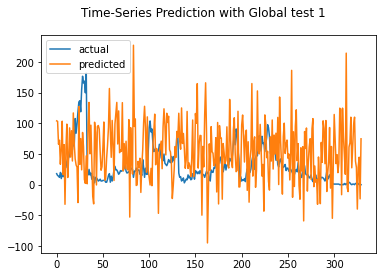

Test MAE: 56.663
Test RMSE: 65.493
Test sMAPE: 109.560
Test R Squared: -3.438
{'mae': 56.66275227683963, 'rmse': 65.49275346168919, 'smape': 109.56025930638515, 'r2': -3.4384210662826025}


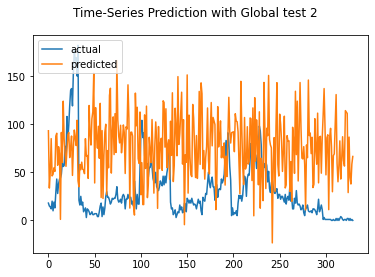

Test MAE: 38.123
Test RMSE: 47.450
Test sMAPE: 97.199
Test R Squared: -1.330
{'mae': 38.123197723157475, 'rmse': 47.45022766976683, 'smape': 97.19869293240409, 'r2': -1.3297997952142118}


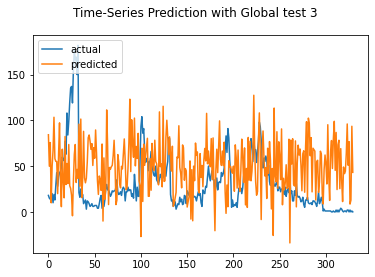

Test MAE: 46.133
Test RMSE: 56.035
Test sMAPE: 104.175
Test R Squared: -2.249
{'mae': 46.133160630861916, 'rmse': 56.03491763961788, 'smape': 104.17530030106762, 'r2': -2.249073062752633}


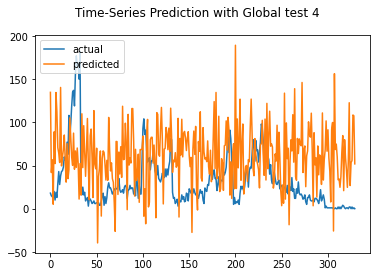

Test MAE: 39.998
Test RMSE: 50.199
Test sMAPE: 103.927
Test R Squared: -1.608
{'mae': 39.99775948235483, 'rmse': 50.19886240637993, 'smape': 103.92718610154292, 'r2': -1.607532633936553}


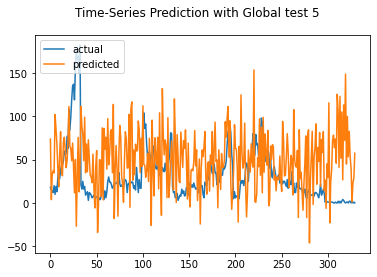

Test MAE: 36.823
Test RMSE: 46.865
Test sMAPE: 102.503
Test R Squared: -1.273
{'mae': 36.8233311247645, 'rmse': 46.86516068792451, 'smape': 102.50346116163956, 'r2': -1.2727005787837902}


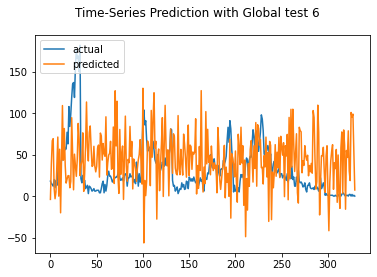

Test MAE: 45.259
Test RMSE: 54.936
Test sMAPE: 103.275
Test R Squared: -2.123
{'mae': 45.25887179121827, 'rmse': 54.93615975388294, 'smape': 103.27548160044812, 'r2': -2.122903729158574}


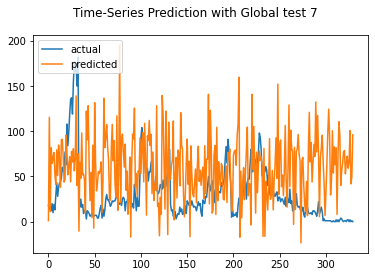

Test MAE: 52.069
Test RMSE: 61.101
Test sMAPE: 106.331
Test R Squared: -2.863
{'mae': 52.068831537709094, 'rmse': 61.1005282756403, 'smape': 106.3308509387187, 'r2': -2.8630642559794746}


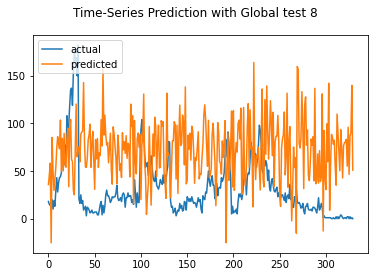

Test MAE: 54.729
Test RMSE: 63.878
Test sMAPE: 107.995
Test R Squared: -3.222
{'mae': 54.72892344250823, 'rmse': 63.8783297615911, 'smape': 107.99478996652637, 'r2': -3.222300179602814}


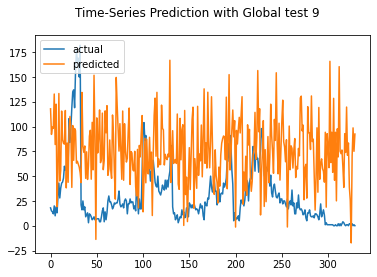

Test MAE: 46.633
Test RMSE: 56.962
Test sMAPE: 104.895
Test R Squared: -2.357
{'mae': 46.63306459910942, 'rmse': 56.96193070272503, 'smape': 104.89458959112956, 'r2': -2.357464303152706}


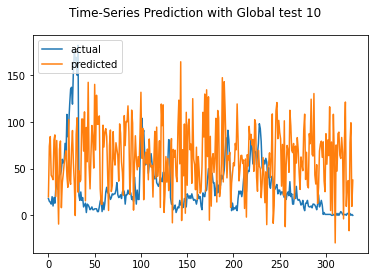

Test MAE: 61.843
Test RMSE: 70.336
Test sMAPE: 110.804
Test R Squared: -4.119
{'mae': 61.84311764457009, 'rmse': 70.33611663295997, 'smape': 110.80385767626534, 'r2': -4.119160838102421}


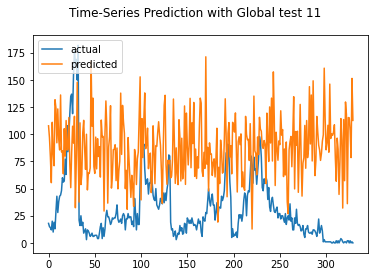

Test MAE: 42.518
Test RMSE: 51.992
Test sMAPE: 104.538
Test R Squared: -1.797
{'mae': 42.518291939749865, 'rmse': 51.99173833837407, 'smape': 104.53843624450847, 'r2': -1.7971172926439585}


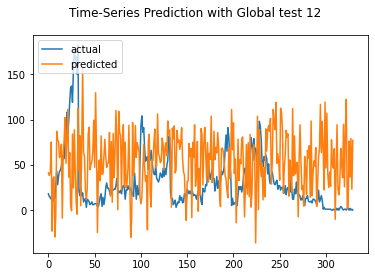

Test MAE: 39.495
Test RMSE: 49.295
Test sMAPE: 102.637
Test R Squared: -1.515
{'mae': 39.49543160434925, 'rmse': 49.29525927029535, 'smape': 102.63732786319883, 'r2': -1.5145038907581854}


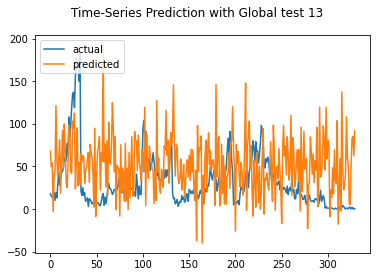

Test MAE: 46.468
Test RMSE: 55.554
Test sMAPE: 103.914
Test R Squared: -2.194
{'mae': 46.4681097167911, 'rmse': 55.5537657384926, 'smape': 103.91372354406437, 'r2': -2.193515349593905}


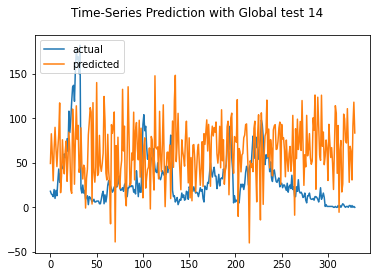

Test MAE: 50.100
Test RMSE: 61.272
Test sMAPE: 103.387
Test R Squared: -2.885
{'mae': 50.09960768150561, 'rmse': 61.272116732597716, 'smape': 103.38737481765484, 'r2': -2.8847919890672538}


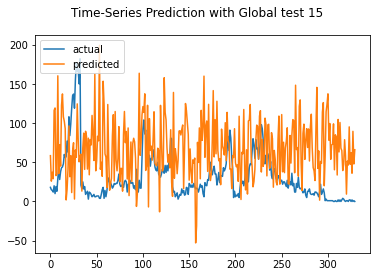

Test MAE: 51.356
Test RMSE: 61.474
Test sMAPE: 105.943
Test R Squared: -2.910
{'mae': 51.355976004672776, 'rmse': 61.473684853060476, 'smape': 105.94337788168195, 'r2': -2.91039378869539}


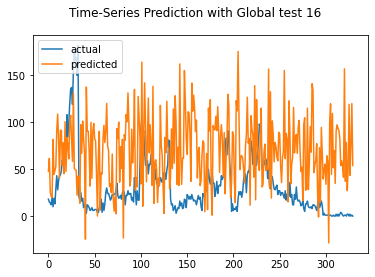

Test MAE: 38.988
Test RMSE: 49.510
Test sMAPE: 99.983
Test R Squared: -1.536
{'mae': 38.98796651688489, 'rmse': 49.50999993600638, 'smape': 99.98320898925282, 'r2': -1.5364590382312167}


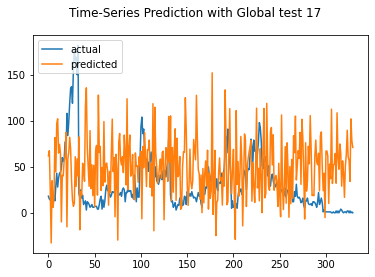

Test MAE: 42.954
Test RMSE: 54.168
Test sMAPE: 106.248
Test R Squared: -2.036
{'mae': 42.95402976075808, 'rmse': 54.168238236422646, 'smape': 106.24780503535638, 'r2': -2.0362073228242075}


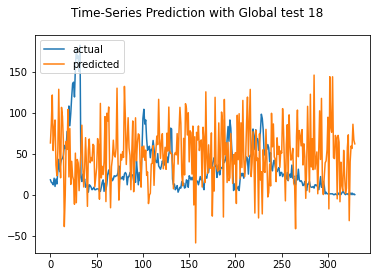

Test MAE: 48.089
Test RMSE: 56.752
Test sMAPE: 105.878
Test R Squared: -2.333
{'mae': 48.08944889415394, 'rmse': 56.75206750793782, 'smape': 105.8777828068383, 'r2': -2.3327702595140005}


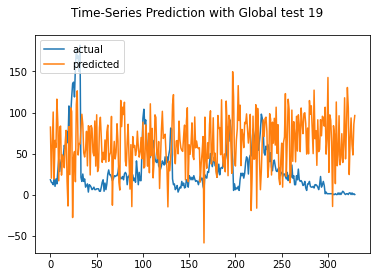

Test MAE: 61.164
Test RMSE: 70.416
Test sMAPE: 110.620
Test R Squared: -4.131
{'mae': 61.16400254278472, 'rmse': 70.41625081421076, 'smape': 110.61955937849001, 'r2': -4.130832038177122}


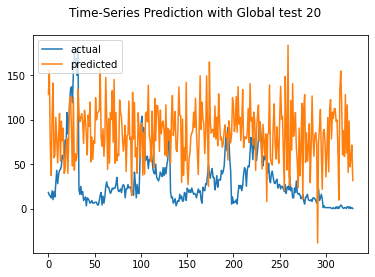

Test MAE: 47.548
Test RMSE: 58.175
Test sMAPE: 104.015
Test R Squared: -2.502
{'mae': 47.547624723116556, 'rmse': 58.17458735757545, 'smape': 104.01502374247906, 'r2': -2.501939384464314}


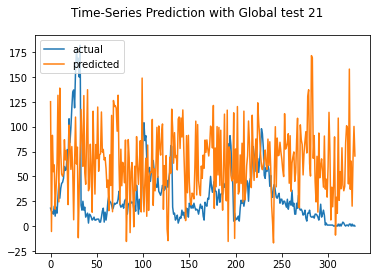

Test MAE: 47.012
Test RMSE: 56.780
Test sMAPE: 100.728
Test R Squared: -2.336
{'mae': 47.01209846843373, 'rmse': 56.780081051049635, 'smape': 100.72839255476372, 'r2': -2.336061267223743}


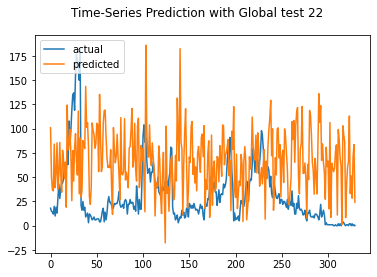

Test MAE: 35.085
Test RMSE: 45.487
Test sMAPE: 104.429
Test R Squared: -1.141
{'mae': 35.085478315931375, 'rmse': 45.48700397536141, 'smape': 104.42861233427178, 'r2': -1.140999999309015}


Test MAE: 66.468
Test RMSE: 74.737
Test sMAPE: 114.589
Test R Squared: -4.780
{'mae': 66.46815943862453, 'rmse': 74.73700225208718, 'smape': 114.58851870154079, 'r2': -4.779807174252965}


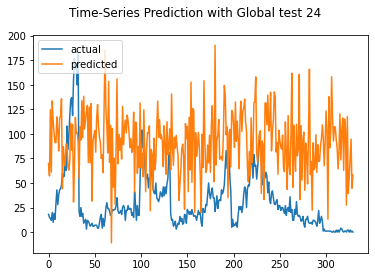

Test MAE: 57.691
Test RMSE: 66.833
Test sMAPE: 109.781
Test R Squared: -3.622
{'mae': 57.690672090920536, 'rmse': 66.83324922736261, 'smape': 109.78109383345404, 'r2': -3.6219703278530817}


Test MAE: 56.931
Test RMSE: 66.375
Test sMAPE: 109.671
Test R Squared: -3.559
{'mae': 56.93086869102536, 'rmse': 66.37496934289179, 'smape': 109.67076189290574, 'r2': -3.558801354736124}


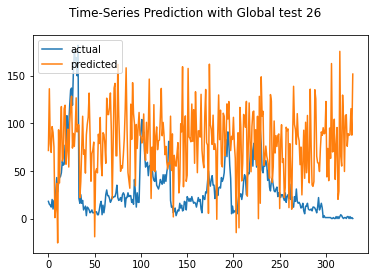

Test MAE: 43.388
Test RMSE: 52.149
Test sMAPE: 100.709
Test R Squared: -1.814
{'mae': 43.38801531574943, 'rmse': 52.14854903924168, 'smape': 100.70851905838084, 'r2': -1.8140153379179558}


Test MAE: 41.558
Test RMSE: 52.769
Test sMAPE: 98.282
Test R Squared: -1.881
{'mae': 41.55753358367718, 'rmse': 52.76941810744161, 'smape': 98.28223591920766, 'r2': -1.8814203037195911}


Test MAE: 37.442
Test RMSE: 46.783
Test sMAPE: 101.322
Test R Squared: -1.265
{'mae': 37.44164384097764, 'rmse': 46.783224801080124, 'smape': 101.32237261051006, 'r2': -1.2647606527831572}


Test MAE: 44.733
Test RMSE: 54.624
Test sMAPE: 106.799
Test R Squared: -2.088
{'mae': 44.733375959324114, 'rmse': 54.62405265173337, 'smape': 106.7994435646008, 'r2': -2.087520414173245}


Test MAE: 72.979
Test RMSE: 82.604
Test sMAPE: 117.307
Test R Squared: -6.061
{'mae': 72.97877668033946, 'rmse': 82.60392113794808, 'smape': 117.30738599647032, 'r2': -6.060627964815962}


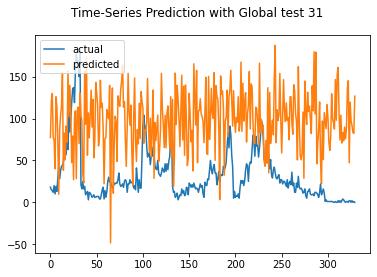

Test MAE: 65.137
Test RMSE: 73.182
Test sMAPE: 112.988
Test R Squared: -4.542
{'mae': 65.13681570688884, 'rmse': 73.1818211117576, 'smape': 112.98788895826794, 'r2': -4.541769101104453}


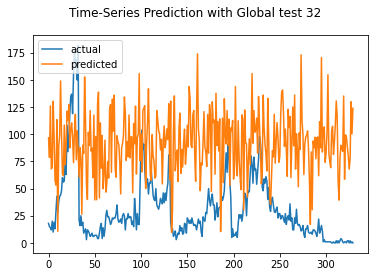

Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
Test MAE: 47.701
Test RMSE: 61.319
Test sMAPE: 116.052
Test R Squared: -2.891
{'mae': 47.70145270056797, 'rmse': 61.31899533078595, 'smape': 116.05159781576542, 'r2': -2.8907386832223247}


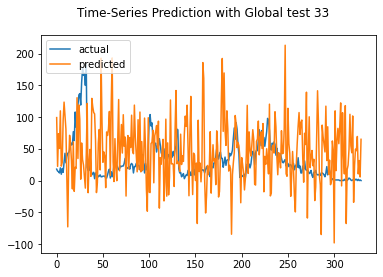

Test MAE: 66.815
Test RMSE: 75.636
Test sMAPE: 116.357
Test R Squared: -4.920
{'mae': 66.81466121167847, 'rmse': 75.63625964705884, 'smape': 116.35714806631057, 'r2': -4.919732601002091}


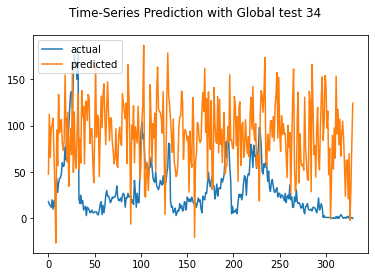

Test MAE: 83.576
Test RMSE: 93.647
Test sMAPE: 122.945
Test R Squared: -8.075
{'mae': 83.57577092033443, 'rmse': 93.64678723839836, 'smape': 122.94518513391301, 'r2': -8.07460576471307}


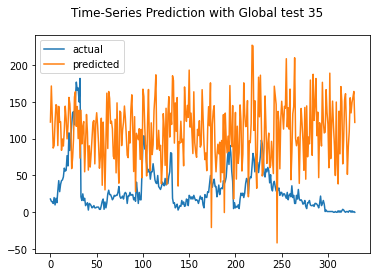

Test MAE: 42.256
Test RMSE: 50.997
Test sMAPE: 100.530
Test R Squared: -1.691
{'mae': 42.25639879170692, 'rmse': 50.997049945130634, 'smape': 100.5296909942235, 'r2': -1.6911140866396779}


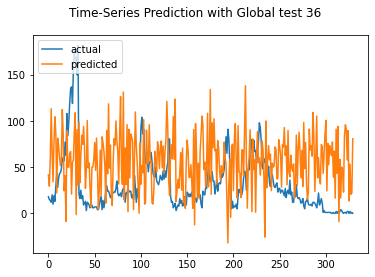

Test MAE: 46.821
Test RMSE: 56.714
Test sMAPE: 104.499
Test R Squared: -2.328
{'mae': 46.82144351728035, 'rmse': 56.71438706528808, 'smape': 104.4990747138112, 'r2': -2.328346153935578}


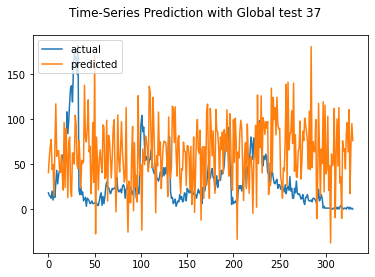

Test MAE: 41.236
Test RMSE: 50.299
Test sMAPE: 104.779
Test R Squared: -1.618
{'mae': 41.2357080802773, 'rmse': 50.29859539885008, 'smape': 104.77877928059237, 'r2': -1.6179039991534068}


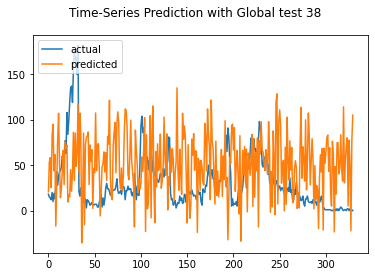

Test MAE: 35.458
Test RMSE: 45.456
Test sMAPE: 102.169
Test R Squared: -1.138
{'mae': 35.45799131808859, 'rmse': 45.45589936367314, 'smape': 102.16949893448786, 'r2': -1.138072912513865}


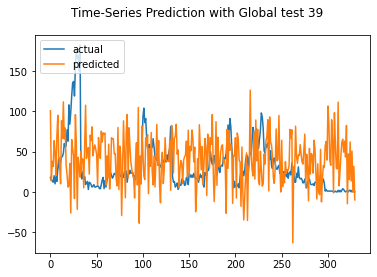

Test MAE: 57.667
Test RMSE: 66.943
Test sMAPE: 109.230
Test R Squared: -3.637
{'mae': 57.66731259172613, 'rmse': 66.94336985625628, 'smape': 109.23041133805245, 'r2': -3.6372140456616764}


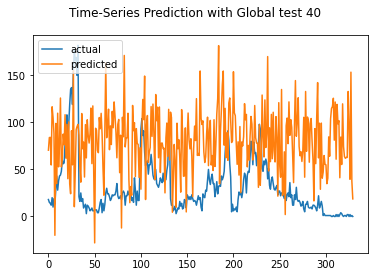

Test MAE: 45.819
Test RMSE: 54.483
Test sMAPE: 101.224
Test R Squared: -2.072
{'mae': 45.81940903157899, 'rmse': 54.482652214804176, 'smape': 101.22356760719916, 'r2': -2.0715563232388607}


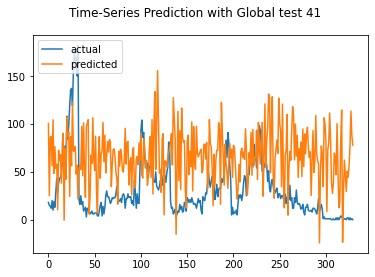

Test MAE: 48.240
Test RMSE: 57.841
Test sMAPE: 104.501
Test R Squared: -2.462
{'mae': 48.23951058821245, 'rmse': 57.840922773251854, 'smape': 104.50115065090561, 'r2': -2.461883330076091}


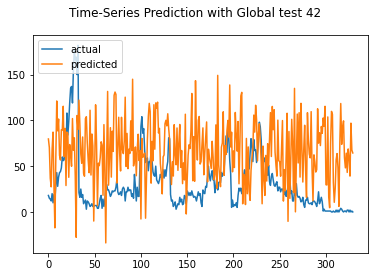

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 57.966
Test RMSE: 70.411
Test sMAPE: 115.427
Test R Squared: -4.130
{'mae': 57.96621141849142, 'rmse': 70.41057079451416, 'smape': 115.4269942634037, 'r2': -4.130004330047174}


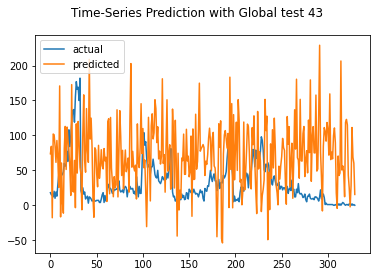

Test MAE: 37.400
Test RMSE: 46.765
Test sMAPE: 100.307
Test R Squared: -1.263
{'mae': 37.39967135353522, 'rmse': 46.76534712960738, 'smape': 100.30684359268675, 'r2': -1.263030079016533}


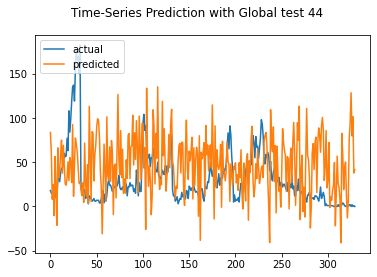

Test MAE: 60.305
Test RMSE: 67.614
Test sMAPE: 111.493
Test R Squared: -3.731
{'mae': 60.30466492103808, 'rmse': 67.61429512579718, 'smape': 111.49321199728293, 'r2': -3.730630761054452}


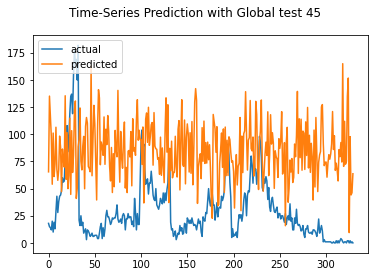

Test MAE: 78.009
Test RMSE: 86.889
Test sMAPE: 122.313
Test R Squared: -6.812
{'mae': 78.00898396986904, 'rmse': 86.88921476400482, 'smape': 122.31310808600084, 'r2': -6.812207076607868}


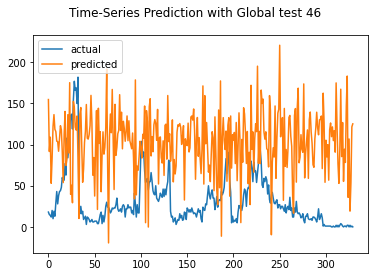

Test MAE: 64.242
Test RMSE: 72.865
Test sMAPE: 112.920
Test R Squared: -4.494
{'mae': 64.24231461900654, 'rmse': 72.86494014678954, 'smape': 112.91982007012433, 'r2': -4.493880727900519}


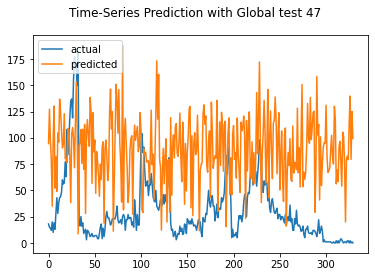

Test MAE: 50.505
Test RMSE: 61.102
Test sMAPE: 103.588
Test R Squared: -2.863
{'mae': 50.50507363117102, 'rmse': 61.10232144652299, 'smape': 103.5876049099554, 'r2': -2.8632910047878943}


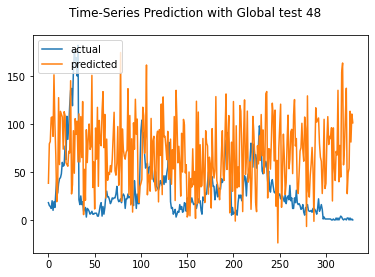

Test MAE: 51.299
Test RMSE: 60.459
Test sMAPE: 108.942
Test R Squared: -2.782
{'mae': 51.29931769786459, 'rmse': 60.45893519420396, 'smape': 108.94166761961782, 'r2': -2.782361113052519}


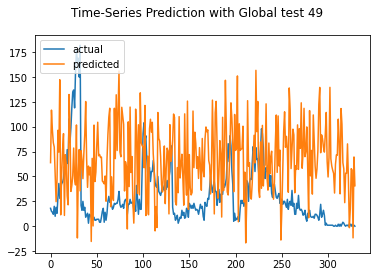

Test MAE: 39.775
Test RMSE: 49.298
Test sMAPE: 100.233
Test R Squared: -1.515
{'mae': 39.77505394617717, 'rmse': 49.298436632417335, 'smape': 100.23349348975434, 'r2': -1.5148280495929516}


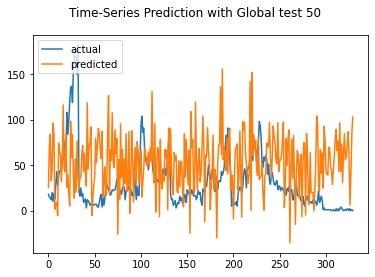

Test MAE: 45.450
Test RMSE: 53.232
Test sMAPE: 101.154
Test R Squared: -1.932
{'mae': 45.449755772496715, 'rmse': 53.231546874964835, 'smape': 101.15393942565045, 'r2': -1.932109432255654}


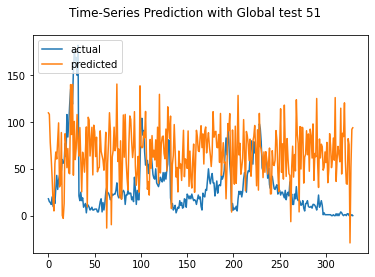

Test MAE: 40.624
Test RMSE: 51.723
Test sMAPE: 106.343
Test R Squared: -1.768
{'mae': 40.62449594338735, 'rmse': 51.72309534493258, 'smape': 106.34322484009684, 'r2': -1.7682863796823622}


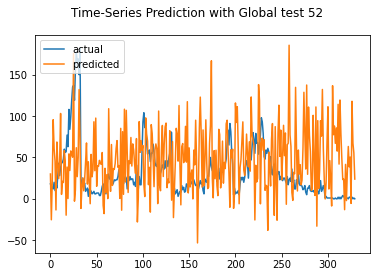

Test MAE: 42.689
Test RMSE: 51.668
Test sMAPE: 105.900
Test R Squared: -1.762
{'mae': 42.688777077378646, 'rmse': 51.66800742961897, 'smape': 105.89992607634842, 'r2': -1.7623927681461025}


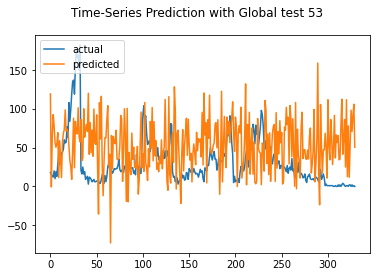

Test MAE: 48.647
Test RMSE: 57.162
Test sMAPE: 103.428
Test R Squared: -2.381
{'mae': 48.647395730741096, 'rmse': 57.16249398824143, 'smape': 103.42810846463712, 'r2': -2.381149229485657}


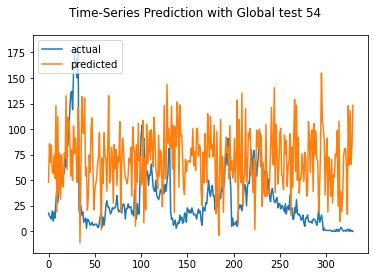

Test MAE: 44.440
Test RMSE: 54.342
Test sMAPE: 105.638
Test R Squared: -2.056
{'mae': 44.44038360588478, 'rmse': 54.341846443506356, 'smape': 105.63789823565845, 'r2': -2.055700487696546}


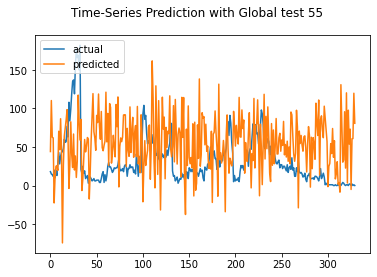

Test MAE: 54.402
Test RMSE: 63.838
Test sMAPE: 107.755
Test R Squared: -3.217
{'mae': 54.40230914751689, 'rmse': 63.837890088176195, 'smape': 107.7554139503646, 'r2': -3.216955819698309}


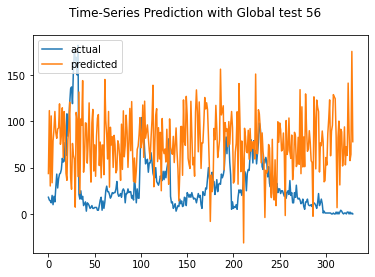

Test MAE: 56.208
Test RMSE: 65.565
Test sMAPE: 108.716
Test R Squared: -3.448
{'mae': 56.20792028976209, 'rmse': 65.5646909707358, 'smape': 108.71606731810876, 'r2': -3.448176781010477}


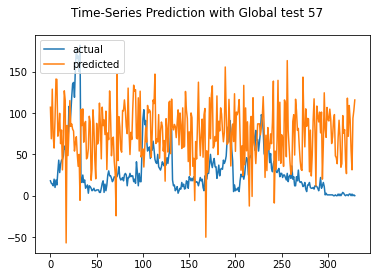

Test MAE: 47.213
Test RMSE: 56.511
Test sMAPE: 101.673
Test R Squared: -2.304
{'mae': 47.21302904035106, 'rmse': 56.51053399633884, 'smape': 101.67306446314338, 'r2': -2.3044624718183746}


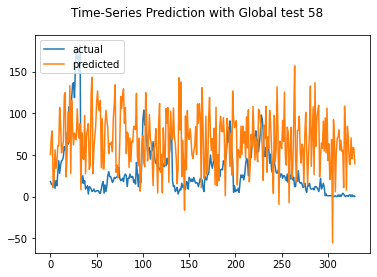

Test MAE: 35.106
Test RMSE: 45.093
Test sMAPE: 101.274
Test R Squared: -1.104
{'mae': 35.10573132056179, 'rmse': 45.09334182488533, 'smape': 101.27379251349278, 'r2': -1.1041022703292764}


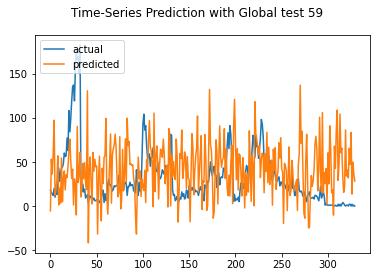

Test MAE: 36.932
Test RMSE: 49.122
Test sMAPE: 117.500
Test R Squared: -1.497
{'mae': 36.93158091288625, 'rmse': 49.12222601818062, 'smape': 117.50013929806804, 'r2': -1.4968823517360645}


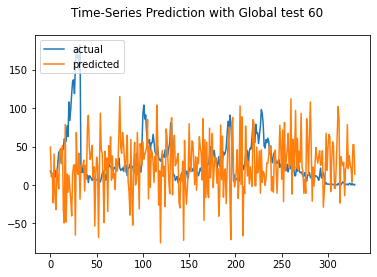

Test MAE: 40.543
Test RMSE: 50.516
Test sMAPE: 96.201
Test R Squared: -1.641
{'mae': 40.54345269817294, 'rmse': 50.516493053962826, 'smape': 96.20050881673868, 'r2': -1.6406350803769172}


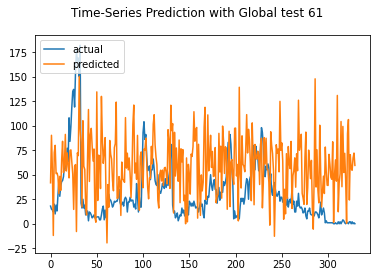

Test MAE: 70.423
Test RMSE: 78.390
Test sMAPE: 116.471
Test R Squared: -5.359
{'mae': 70.42283877080138, 'rmse': 78.39020732796688, 'smape': 116.4708470205442, 'r2': -5.358660353018571}


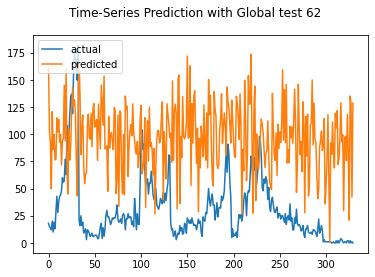

Test MAE: 42.856
Test RMSE: 53.208
Test sMAPE: 107.279
Test R Squared: -1.930
{'mae': 42.855870656172435, 'rmse': 53.20847085058252, 'smape': 107.27891166589617, 'r2': -1.9295678279998176}


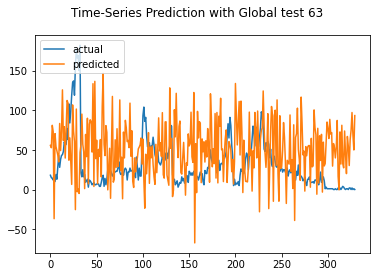

Test MAE: 40.498
Test RMSE: 50.999
Test sMAPE: 100.331
Test R Squared: -1.691
{'mae': 40.49820295752901, 'rmse': 50.99923778173356, 'smape': 100.33143555100973, 'r2': -1.691344995847286}


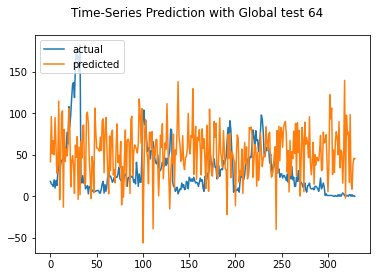

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 46.015
Test RMSE: 57.200
Test sMAPE: 109.158
Test R Squared: -2.386
{'mae': 46.014933231563276, 'rmse': 57.20008884673254, 'smape': 109.15818985462346, 'r2': -2.3855981475896115}


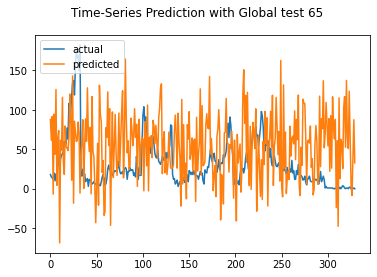

Test MAE: 37.049
Test RMSE: 45.714
Test sMAPE: 100.240
Test R Squared: -1.162
{'mae': 37.048668779207, 'rmse': 45.71390843283016, 'smape': 100.24018174760457, 'r2': -1.162413329430529}


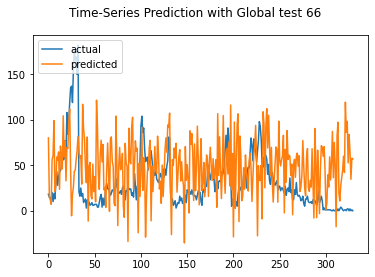

Test MAE: 36.284
Test RMSE: 45.646
Test sMAPE: 97.549
Test R Squared: -1.156
{'mae': 36.2836608476711, 'rmse': 45.6463344677845, 'smape': 97.54930262442396, 'r2': -1.156025127288805}


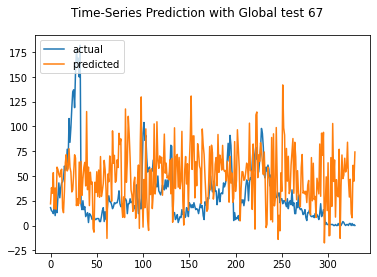

Test MAE: 58.197
Test RMSE: 66.472
Test sMAPE: 108.921
Test R Squared: -3.572
{'mae': 58.196959931561445, 'rmse': 66.47203545507244, 'smape': 108.92053088157384, 'r2': -3.5721445980007216}


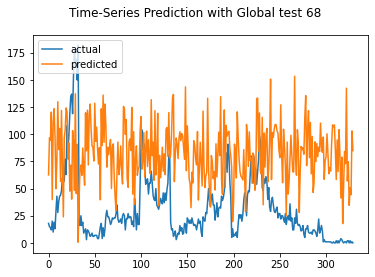

Test MAE: 36.976
Test RMSE: 45.394
Test sMAPE: 95.895
Test R Squared: -1.132
{'mae': 36.97564626227726, 'rmse': 45.394184083510915, 'smape': 95.89477640829513, 'r2': -1.1322711488056174}


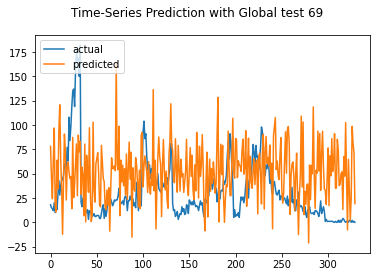

Test MAE: 44.324
Test RMSE: 53.582
Test sMAPE: 104.661
Test R Squared: -1.971
{'mae': 44.323570654789606, 'rmse': 53.5816230608669, 'smape': 104.66083015847546, 'r2': -1.9708021623887282}


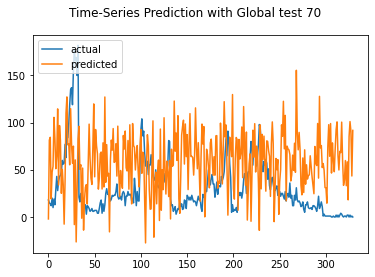

Test MAE: 46.609
Test RMSE: 55.991
Test sMAPE: 102.788
Test R Squared: -2.244
{'mae': 46.60927242293502, 'rmse': 55.9910008880986, 'smape': 102.78823513606375, 'r2': -2.2439822077997373}


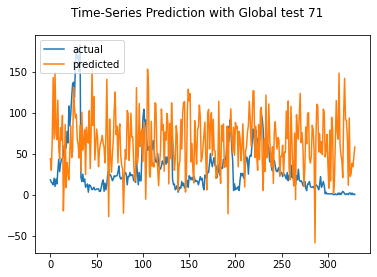

Test MAE: 53.686
Test RMSE: 64.088
Test sMAPE: 106.612
Test R Squared: -3.250
{'mae': 53.685860094518375, 'rmse': 64.0880047478321, 'smape': 106.61224757161172, 'r2': -3.2500643278699934}


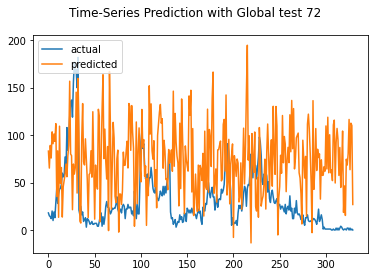

Test MAE: 35.313
Test RMSE: 47.123
Test sMAPE: 122.377
Test R Squared: -1.298
{'mae': 35.31271195736798, 'rmse': 47.123043022888425, 'smape': 122.37652332937684, 'r2': -1.2977811223698983}


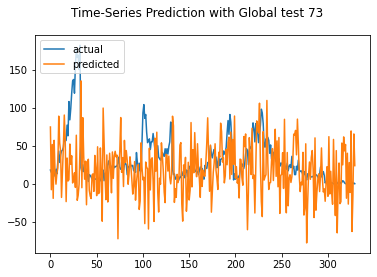

Test MAE: 34.297
Test RMSE: 44.118
Test sMAPE: 99.835
Test R Squared: -1.014
{'mae': 34.2971216460069, 'rmse': 44.1179396007175, 'smape': 99.8347534055609, 'r2': -1.0140601899070272}


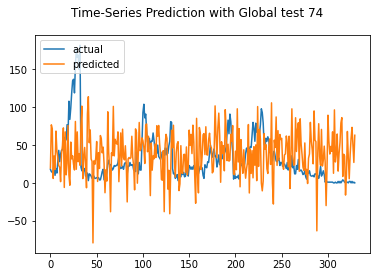

Test MAE: 49.649
Test RMSE: 59.237
Test sMAPE: 104.585
Test R Squared: -2.631
{'mae': 49.649285501061065, 'rmse': 59.23660387775342, 'smape': 104.58533071757644, 'r2': -2.630967028820569}


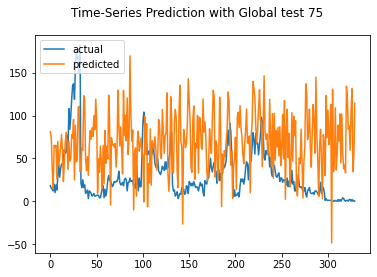

Test MAE: 40.300
Test RMSE: 49.962
Test sMAPE: 100.938
Test R Squared: -1.583
{'mae': 40.30038316015041, 'rmse': 49.961649253608584, 'smape': 100.93799743470012, 'r2': -1.5829472326220162}


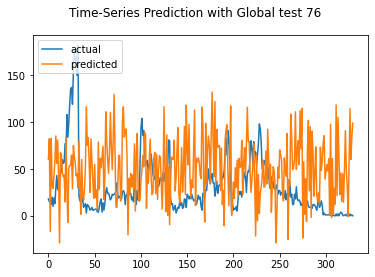

Test MAE: 58.631
Test RMSE: 67.041
Test sMAPE: 110.373
Test R Squared: -3.651
{'mae': 58.631397634564024, 'rmse': 67.0406149909798, 'smape': 110.37339318320032, 'r2': -3.6506963080213666}


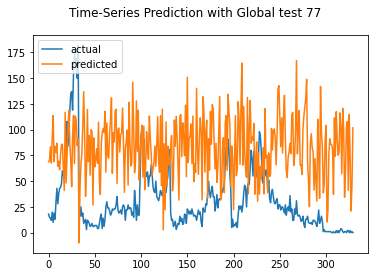

Test MAE: 43.216
Test RMSE: 53.428
Test sMAPE: 105.789
Test R Squared: -1.954
{'mae': 43.21594723607554, 'rmse': 53.4275046870468, 'smape': 105.78916227043237, 'r2': -1.9537367320785064}


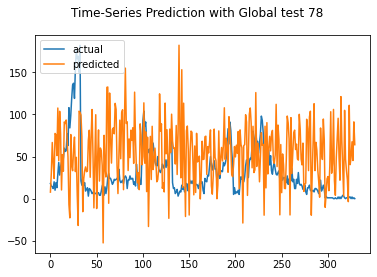

Test MAE: 61.170
Test RMSE: 70.809
Test sMAPE: 113.289
Test R Squared: -4.188
{'mae': 61.17004635063085, 'rmse': 70.80898544776893, 'smape': 113.28935913346989, 'r2': -4.188224322801254}


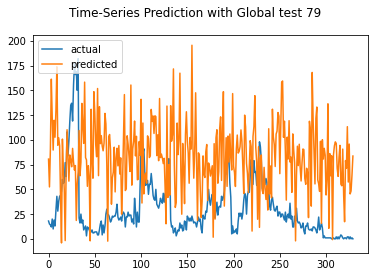

Test MAE: 42.993
Test RMSE: 52.933
Test sMAPE: 103.091
Test R Squared: -1.899
{'mae': 42.99266253240181, 'rmse': 52.933427085268306, 'smape': 103.09126751808974, 'r2': -1.899359224041739}


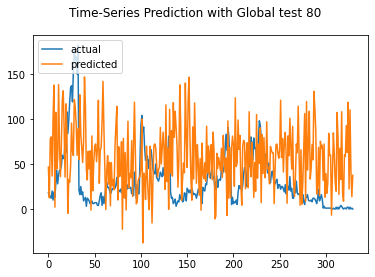

Test MAE: 43.118
Test RMSE: 52.009
Test sMAPE: 101.567
Test R Squared: -1.799
{'mae': 43.118364770845936, 'rmse': 52.00927543413141, 'smape': 101.56662508365483, 'r2': -1.7990045765989944}


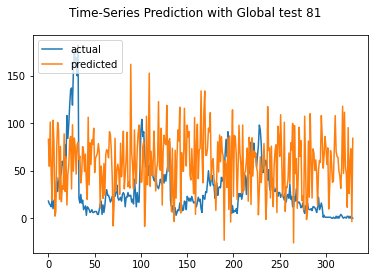

Test MAE: 34.596
Test RMSE: 44.698
Test sMAPE: 99.795
Test R Squared: -1.067
{'mae': 34.596272584344405, 'rmse': 44.6980782945451, 'smape': 99.79498450725856, 'r2': -1.0673771195721242}


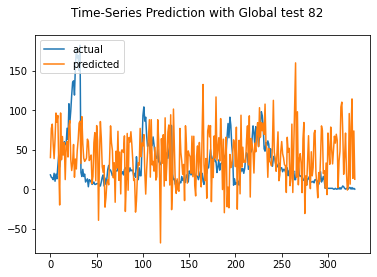

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 55.256
Test RMSE: 68.493
Test sMAPE: 114.055
Test R Squared: -3.854
{'mae': 55.25567589673129, 'rmse': 68.49332367314304, 'smape': 114.05504535390708, 'r2': -3.85443269164237}


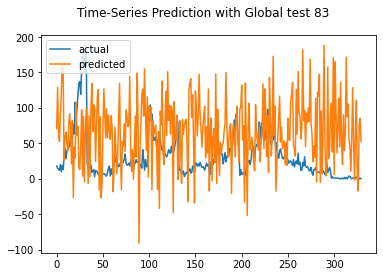

Test MAE: 40.090
Test RMSE: 51.107
Test sMAPE: 107.141
Test R Squared: -1.703
{'mae': 40.08975360465772, 'rmse': 51.10727575825625, 'smape': 107.14092790358849, 'r2': -1.7027598900470338}


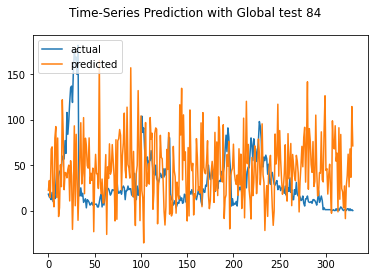

Test MAE: 42.518
Test RMSE: 51.466
Test sMAPE: 101.376
Test R Squared: -1.741
{'mae': 42.51771937048797, 'rmse': 51.46627415018279, 'smape': 101.37642928330244, 'r2': -1.7408638305973572}


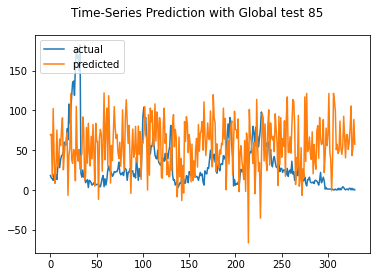

Test MAE: 48.756
Test RMSE: 57.544
Test sMAPE: 101.335
Test R Squared: -2.426
{'mae': 48.75631896799261, 'rmse': 57.544115299052216, 'smape': 101.33531061308128, 'r2': -2.4264455643712255}


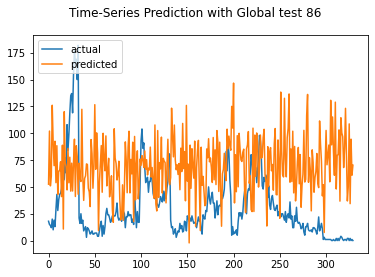

Test MAE: 40.663
Test RMSE: 49.340
Test sMAPE: 98.883
Test R Squared: -1.519
{'mae': 40.66338910117294, 'rmse': 49.34009901626923, 'smape': 98.88274560030297, 'r2': -1.5190804361234918}


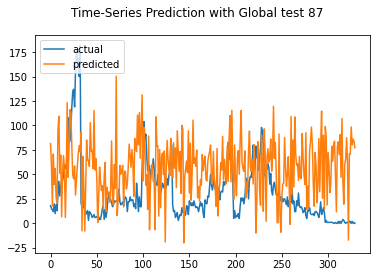

Test MAE: 50.269
Test RMSE: 59.993
Test sMAPE: 105.304
Test R Squared: -2.724
{'mae': 50.26907596443639, 'rmse': 59.99341512087491, 'smape': 105.30360798053196, 'r2': -2.7243387125047334}


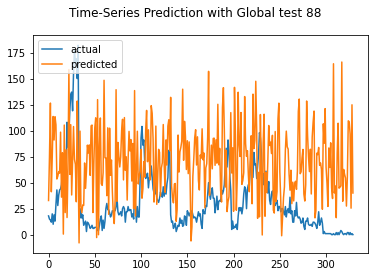

Test MAE: 48.121
Test RMSE: 59.481
Test sMAPE: 103.950
Test R Squared: -2.661
{'mae': 48.12085856560505, 'rmse': 59.48132690005776, 'smape': 103.94977433817678, 'r2': -2.6610300863223357}


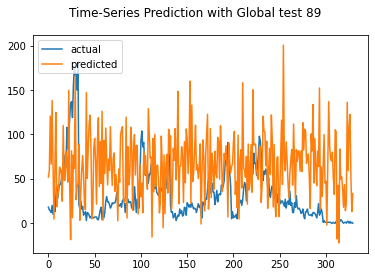

Test MAE: 45.694
Test RMSE: 55.826
Test sMAPE: 106.203
Test R Squared: -2.225
{'mae': 45.693584287527834, 'rmse': 55.82599433577674, 'smape': 106.20278312954973, 'r2': -2.224890226099366}


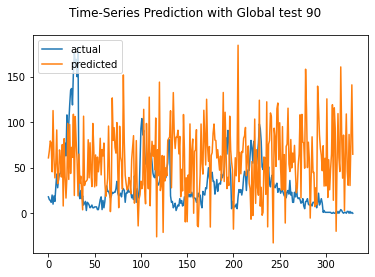

Test MAE: 57.203
Test RMSE: 65.604
Test sMAPE: 110.132
Test R Squared: -3.453
{'mae': 57.203372633095945, 'rmse': 65.6038685799838, 'smape': 110.13177355802556, 'r2': -3.4534943077356592}


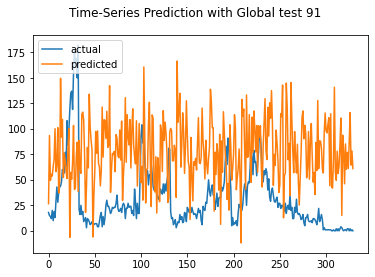

Test MAE: 38.397
Test RMSE: 49.851
Test sMAPE: 103.026
Test R Squared: -1.571
{'mae': 38.39706637805158, 'rmse': 49.8506509675211, 'smape': 103.02571883498456, 'r2': -1.5714830699782847}


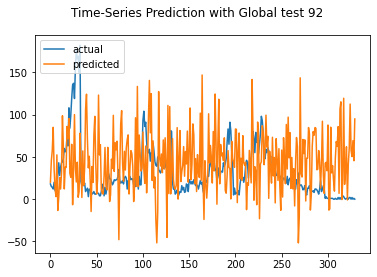

Test MAE: 43.762
Test RMSE: 53.391
Test sMAPE: 104.890
Test R Squared: -1.950
{'mae': 43.76153287327651, 'rmse': 53.39077008002056, 'smape': 104.88977037749893, 'r2': -1.9496763868639126}


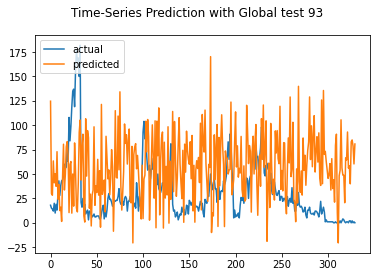

Test MAE: 54.595
Test RMSE: 64.002
Test sMAPE: 107.526
Test R Squared: -3.239
{'mae': 54.59467932021979, 'rmse': 64.00241561879403, 'smape': 107.5255792930791, 'r2': -3.238720039450592}


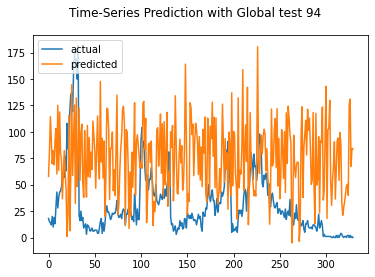

Test MAE: 46.002
Test RMSE: 55.527
Test sMAPE: 103.626
Test R Squared: -2.190
{'mae': 46.00183402065075, 'rmse': 55.52679066581603, 'smape': 103.62554838820218, 'r2': -2.190414771519792}


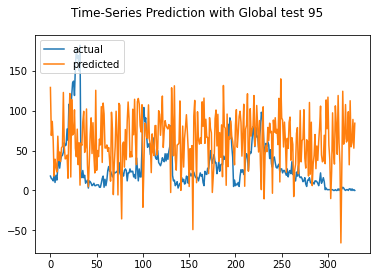

Test MAE: 49.946
Test RMSE: 59.820
Test sMAPE: 104.748
Test R Squared: -2.703
{'mae': 49.94633371125568, 'rmse': 59.81968628689367, 'smape': 104.74837435096109, 'r2': -2.7028000755203365}


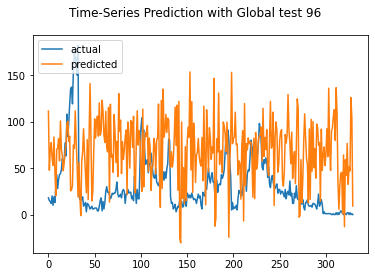

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 40.675
Test RMSE: 50.539
Test sMAPE: 106.470
Test R Squared: -1.643
{'mae': 40.67491410013401, 'rmse': 50.539314437852084, 'smape': 106.46986664176588, 'r2': -1.6430214914463628}


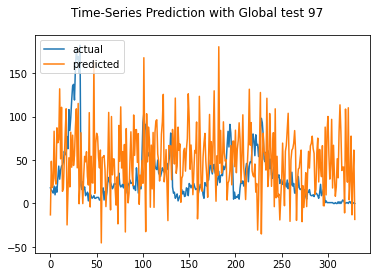

Test MAE: 43.982
Test RMSE: 54.582
Test sMAPE: 102.054
Test R Squared: -2.083
{'mae': 43.9822682001374, 'rmse': 54.581614167888674, 'smape': 102.05420530049201, 'r2': -2.082724769064202}


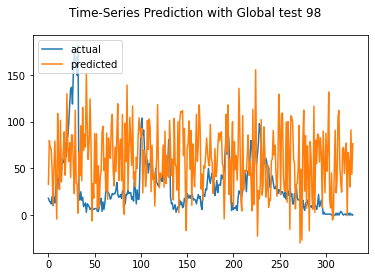

Test MAE: 47.908
Test RMSE: 55.760
Test sMAPE: 103.926
Test R Squared: -2.217
{'mae': 47.90763272805648, 'rmse': 55.75982338982864, 'smape': 103.92590346818355, 'r2': -2.217249786528279}


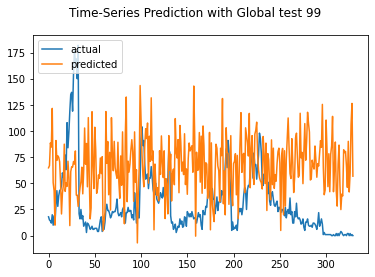

rmse : average=57.919, std=9.575
mae : average=48.214, std=9.816
smape : average=106.104, std=5.700
r2 : average=-2.566, std=1.258


([57.919078863763005, 9.574903543721613],
 [48.21392458992204, 9.816177741578501],
 [106.10403819389076, 5.699941410964563],
 [-2.5661112659562604, 1.2584581900366332])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')